# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [16]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [17]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [18]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

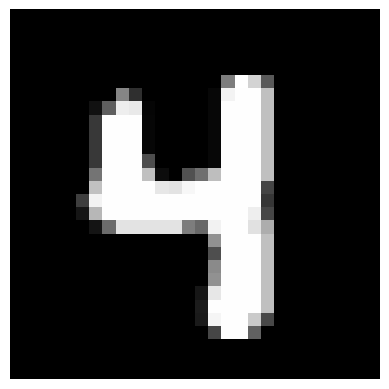

In [19]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [20]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data,train_labels, test_size=0.2, random_state=42, shuffle=True)

In [50]:
def fit_generative_model(x,y, c):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    ###
    for i in list(range(k)):
        pi[i] = len(np.where(y == i)[0])
        mu[i] = np.mean(x[np.where(y == i)[0]], axis = 0)
        sigma[i] = np.cov(x[np.where(y == i)[0]], rowvar= False) + (c*np.eye(784))
    pi = [x/len(y) for x in pi]
    ###
    # Halt and return parameters
    return mu, sigma, pi
    

In [48]:
#check which c value is best based on validation set 
c_list = [1,100,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500, 10000, 20000, 25000, 50000,100000]
err = []
for num in c_list:
    mu, sigma, pi = fit_generative_model(X_valid, y_valid, num)
    k = 10
    score = np.zeros((len(y_valid),k))
    for label in range(0,k):
        rv = multivariate_normal(mean=mu[label], cov=sigma[label])
        for i in range(0,len(y_valid)):
            score[i,label] = np.log(pi[label]) + rv.logpdf(X_valid[i,:])
    predictions = np.argmax(score, axis=1)
    # Finally, tally up score
    errors = np.sum(predictions != y_valid)
    err.append((num, errors))
print(err)
#best c = 3000 (b)

[(1, 313), (100, 156), (1000, 191), (1500, 212), (2000, 230), (2500, 248), (3000, 258), (3500, 272), (4000, 286), (4500, 302), (5000, 316), (5500, 333), (6000, 349), (6500, 358), (7000, 371), (7500, 383), (8000, 393), (8500, 412), (9000, 422), (9500, 432), (10000, 448), (20000, 671), (25000, 762), (50000, 1156), (100000, 1711)]


Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

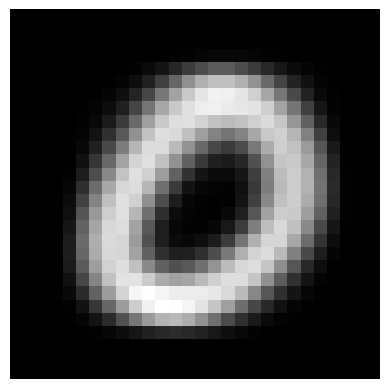

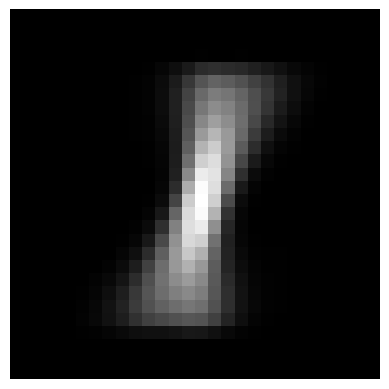

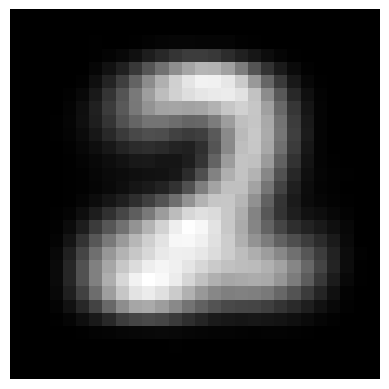

In [54]:
mu, sigma, pi = fit_generative_model(test_data, test_labels, 100)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [57]:
# Compute log Pr(label|image) for each [test image,label] pair.
mu, sigma, pi = fit_generative_model(test_data, test_labels, 100)
k = 10
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")

Your model makes 51 errors out of 10000


In [58]:
(51/10000)*100

0.51

In [56]:
#TRAIN
mu, sigma, pi = fit_generative_model(train_data, train_labels, 100)
k = 10
score = np.zeros((len(train_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(train_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(train_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != train_labels)
print("Your model makes " + str(errors) + " errors out of 60000")

Your model makes 3803 errors out of 60000


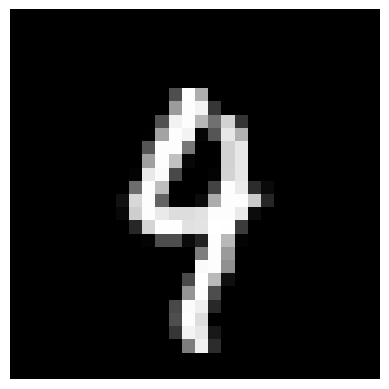

[-4169.36294049 -3945.00278788 -3195.34785491 -3403.23685137
 -3500.35811641 -3814.87154671 -5228.22711214 -3473.39620816
 -3167.21031384 -3401.31650838]


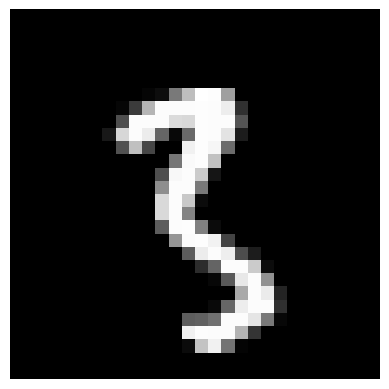

[-4243.10994065 -5532.13179164 -4082.97986596 -3643.73288332
 -3197.48070175 -3789.3359412  -4982.77680023 -3067.3231841
 -3288.55926954 -3058.45807923]


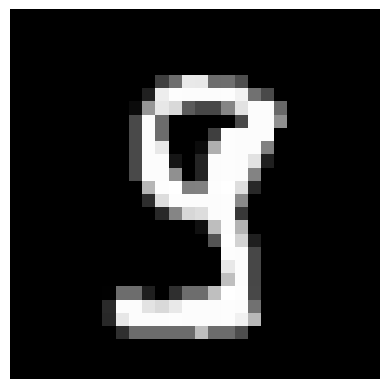

[-5058.33750359 -6038.88966208 -4502.26940313 -3339.61308651
 -3855.1444129  -3921.79688306 -5643.90872663 -3231.36348791
 -3884.30344492 -3169.71014852]


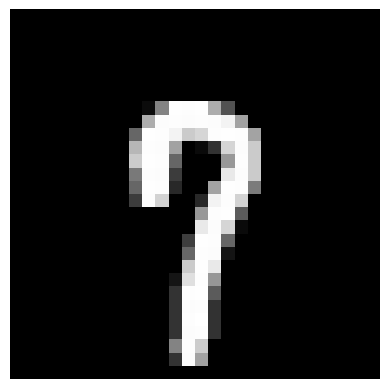

[-3620.52227796 -3275.30449988 -3243.89048139 -3372.13908634
 -3477.745896   -3481.54540186 -4711.44248191 -3464.97236627
 -3132.68004229 -3463.10185539]


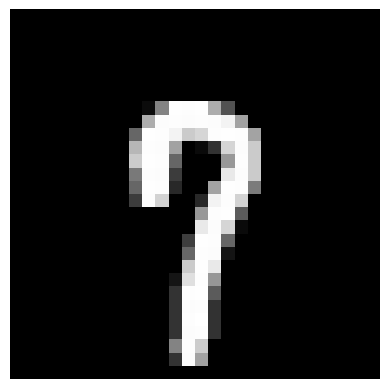

[-3858.9376852  -4338.07668872 -3277.16576666 -3453.63694848
 -3642.41373686 -3526.7178202  -4785.70129418 -4012.69021482
 -3249.23348689 -3806.44013963]


In [62]:
five_miss = test_data[np.random.choice(np.where(predictions != test_labels)[0], 5)]
five_prof = score[np.random.choice(np.where(predictions != test_labels)[0], 5)]
for i in range(len(five_miss)):
    displaychar(five_miss[i])
    print(five_prof[i])

## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

The code will result in an error, since the covariance matrices are not positive semi definite, resulting in one or more of the eigenvalues to be negative. As a result, it cannot be inverted

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

If I set the c too high, the number of errors increase. I believe that this happens because as c is approaching infinity, the regularization gets larger and can wipe out the differences that set the classes apart, which means the model will rely solely the probability of each class instead. 

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

The value of c I ended up using is c = 100. There are 3803 errors the model made on the training seet 

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?